In [1]:
from dotenv import load_dotenv

load_dotenv()

True

In [2]:
from rag.pdf import PDFRetrievalChain

# PDF 문서 로드
pdf = PDFRetrievalChain(["data/SPRI_AI_Brief_2023년12월호_F.pdf"]).create_chain()

# retriever와 chain을 생성
pdf_retriever = pdf.retriever
pdf_chain = pdf.chain

c:\Users\Songjae\AppData\Local\pypoetry\Cache\virtualenvs\langgraph-tutorial-OHVJypTr-py3.11\Lib\site-packages\langsmith\client.py:241: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


In [3]:
from langchain_core.tools.retriever import create_retriever_tool
from langchain_core.prompts import PromptTemplate

# PDF 문서를 기반으로 검색 도구 생성
retriever_tool = create_retriever_tool(
    pdf_retriever,
    # 툴 네임 설정
    "pdf_retriever",
    # 툴에 대한 description
    "Search and return information about SPRI AI Brief PDF file. It contains useful information on recent AI trends. The document is published on Dec 2023.",
    document_prompt=PromptTemplate.from_template(
        "<document><context>{page_content}</context><metadata><source>{source}</source><page>{page}</page></metadata></document>"
    ),
)

# 생성된 검색 도구를 도구 리스트에 추가하여 에이전트에서 사용 가능하도록 설정
tools = [retriever_tool]

In [4]:
print(retriever_tool.invoke("삼성전자가 개발한 생성형 AI의 이름은?"))

<document><context>SPRi AI Brief |
2023-12월호
삼성전자, 자체 개발 생성 AI ‘삼성 가우스’ 공개
KEY Contents
n 삼성전자가 온디바이스에서 작동 가능하며 언어, 코드, 이미지의 3개 모델로 구성된 자체 개발 생성
AI 모델 ‘삼성 가우스’를 공개
n 삼성전자는 삼성 가우스를 다양한 제품에 단계적으로 탑재할 계획으로, 온디바이스 작동이 가능한
삼성 가우스는 외부로 사용자 정보가 유출될 위험이 없다는 장점을 보유
£언어, 코드, 이미지의 3개 모델로 구성된 삼성 가우스, 온디바이스 작동 지원</context><metadata><source>data/SPRI_AI_Brief_2023년12월호_F.pdf</source><page>12</page></metadata></document>

<document><context>▹ 삼성전자, 자체 개발 생성 AI ‘삼성 가우스’ 공개 ···························································10
▹ 구글, 앤스로픽에 20억 달러 투자로 생성 AI 협력 강화 ················································11
▹ IDC, 2027년 AI 소프트웨어 매출 2,500억 달러 돌파 전망···········································12</context><metadata><source>data/SPRI_AI_Brief_2023년12월호_F.pdf</source><page>1</page></metadata></document>

<document><context>£언어, 코드, 이미지의 3개 모델로 구성된 삼성 가우스, 온디바이스 작동 지원
n 삼성전자가 2023년 11월 8일 열린 ‘삼성 AI 포럼 2023’ 행사에서 자체 개발한 생성 AI 모델
‘삼성 가우스’를 최초 공개
∙ 정규분포 이론을 정립한 천재 수학자 가우스(Gauss)의 이름을 본뜬 삼성 가우스는 다양한 상황

In [5]:
from typing import Annotated, Sequence, TypedDict
from langchain_core.messages import BaseMessage
from langgraph.graph.message import add_messages


# 에이전트 상태를 정의하는 타입 딕셔너리, 메세지 시퀀스를 관리하고 추가 동작 정의
class AgentState(TypedDict):
    # add_messages reducer 함수를 사용하여 메세지 시퀀스를 관리
    messages: Annotated[Sequence[BaseMessage], add_messages]

In [6]:
from typing import Literal
from langchain import hub
from langchain_core.messages import HumanMessage
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import PromptTemplate
from pydantic import BaseModel, Field
from langchain_openai import ChatOpenAI
from langgraph.prebuilt import tools_condition
from langchain_core.prompts import load_prompt

In [7]:
# 모델 이름 선택
MODEL_NAME = "gpt-4o"


# 데이터 모델 정의
class grade(BaseModel):
    binary_score: str = Field(
        description="Response 'yes' if the document is relevant to the question or 'no' if it is not."
    )


def grade_documents(state) -> Literal["generate", "rewrite"]:
    # LLM 모델 초기화
    model = ChatOpenAI(temperature=0, model=MODEL_NAME, streaming=True)
    # 구조화된 출력을 위한 LLM 설정
    llm_with_tool = model.with_structured_output(grade)
    # 프롬프트 템플릿 정의
    prompt = PromptTemplate(
        template="""You are a grader assessing relevance of a retrieved document to a user question. \n 
        Here is the retrieved document: \n\n {context} \n\n
        Here is the user question: {question} \n
        If the document contains keyword(s) or semantic meaning related to the user question, grade it as relevant. \n
        Give a binary score 'yes' or 'no' score to indicate whether the document is relevant to the question.""",
        input_variables=["context", "question"],
    )
    # llm + tool 바인딩 체인 생성
    chain = prompt | llm_with_tool
    # 현재 상태에서 메세지 추출
    messages = state["messages"]
    # 가장 마지막 메세지 추출
    last_message = messages[-1]
    # 원래 질문 추출
    question = messages[0].content
    # 검색된 문서 추출
    retrieved_docs = last_message.content
    # 관련성 평가 실행
    scored_result = chain.invoke({"question": question, "context": retrieved_docs})
    # 관련성 여부 추출
    score = scored_result.binary_score
    # 관련성 여부에 따른 결정
    if score == "yes":
        print("==== [DECISION: DOCS RELEVANT] ====")
        return "generate"
    else:
        print("==== [DECISION: DOCS NOT RELEVANT] ====")
        print(score)
        return "rewrite"


def agent(state):
    # 현재 상태에서 메세지 추출
    messages = state["messages"]
    # LLM 모델 초기화
    model = ChatOpenAI(temperature=0, model=MODEL_NAME, streaming=True)
    # retriever tool 바인딩
    model = model.bind_tools(tools)
    # 에이전트 응답 생성
    response = model.invoke(messages)
    # 기존 리스트에 추가되므로 리스트 형태로 반환
    return {"messages": [response]}


def rewrite(state):
    print("==== [QUERY REWRITE] ====")
    # 현재 상태에서 메세지 추출
    messages = state["messages"]
    # 원래 질문 추출
    question = messages[0].content

    # 질문 개선을 위한 프롬프트 구성
    msg = [
        HumanMessage(
            content=f""" \n 
    Look at the input and try to reason about the underlying semantic intent / meaning. \n 
    Here is the initial question:
    \n ------- \n
    {question} 
    \n ------- \n
    Formulate an improved question: """,
        )
    ]
    # LLM 모델로 질문 개선
    model = ChatOpenAI(temperature=0, model=MODEL_NAME, streaming=True)
    # Query-Transform 체인 실행
    response = model.invoke(msg)
    # 재작성된 질문 반환
    return {"messages": [response]}


def generate(state):
    # 현재 상태에서 메세지 추출
    messages = state["messages"]
    # 원래 질문 추출
    question = messages[0].content
    # 가장 마지막 메세지 추출
    docs = messages[-1].content
    # RAG 프롬프트 템플릿 가져오기
    prompt = load_prompt("prompts/rag_prompt.yaml", encoding="utf-8")
    # LLM 모델 초기화
    llm = ChatOpenAI(temperature=0, model_name=MODEL_NAME, streaming=True)
    # RAG 체인 구성
    rag_chain = prompt | llm | StrOutputParser()
    # 답변 생성 실행
    response = rag_chain.invoke({"context": docs, "question": question})
    return {"messages": [response]}

In [8]:
from langgraph.graph import END, StateGraph, START
from langgraph.prebuilt import ToolNode
from langgraph.checkpoint.memory import MemorySaver

# AgentState 기반 상태 그래프 워크플로우 초기화
workflow = StateGraph(AgentState)

# 노드 정의
workflow.add_node("agent", agent)  # 에이전트 노드
retrieve = ToolNode([retriever_tool])
workflow.add_node("retrieve", retrieve)  # 검색 노드
workflow.add_node("rewrite", rewrite)  # 질문 재작성 노드
workflow.add_node("generate", generate)  # 관련 문서 확인 후 응답 생성 노드

# 엣지 연결
workflow.add_edge(START, "agent")

# 검색 여부를 위한 조건부 엣지 추가

workflow.add_conditional_edges(
    "agent",
    # 에이전트 결정 평가
    tools_condition,
    {
        # 조건 출력을 그래프 노드에 매핑
        "tools": "retrieve",
        END: END,
    },
)

# 액션 노드 실행 후 처리될 엣지 정의
workflow.add_conditional_edges(
    "retrieve",
    # 문서 품질 평가
    grade_documents,
)
workflow.add_edge("generate", END)
workflow.add_edge("rewrite", "agent")

# 그래프 컴파일
graph = workflow.compile(checkpointer=MemorySaver())

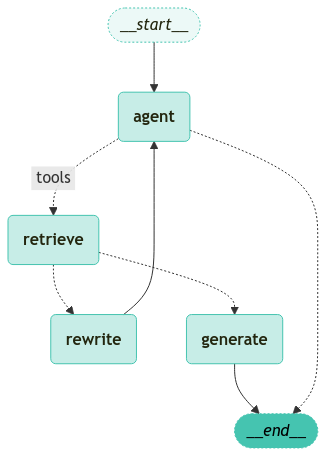

In [9]:
from dataclasses import dataclass


@dataclass
class NodeStyles:
    default: str = (
        "fill:#45C4B0, fill-opacity:0.3, color:#23260F, stroke:#45C4B0, stroke-width:1px, font-weight:bold, line-height:1.2"  # 기본 색상
    )
    first: str = (
        "fill:#45C4B0, fill-opacity:0.1, color:#23260F, stroke:#45C4B0, stroke-width:1px, font-weight:normal, font-style:italic, stroke-dasharray:2,2"  # 점선 테두리
    )
    last: str = (
        "fill:#45C4B0, fill-opacity:1, color:#000000, stroke:#45C4B0, stroke-width:1px, font-weight:normal, font-style:italic, stroke-dasharray:2,2"  # 점선 테두리
    )


from IPython.display import Image, display
from langgraph.graph.state import CompiledStateGraph

if isinstance(graph, CompiledStateGraph):
    display(
        Image(
            graph.get_graph(xray=False).draw_mermaid_png(
                background_color="white",
                node_colors=NodeStyles(),
            )
        )
    )

In [14]:
from langchain_core.runnables import RunnableConfig
from tools.messages import stream_graph, invoke_graph, random_uuid

# config 설정(재귀 최대 횟수, thread_id)
config = RunnableConfig(recursion_limit=10, configurable={"thread_id": random_uuid()})

# 사용자의 에이전트 메모리 유형에 대한 질문을 포함하는 입력 데이터 구조 정의
inputs = {
    "messages": [
        ("user", "삼성전자가 개발한 생성형 AI의 이름은?"),
    ]
}

# 그래프 실행
invoke_graph(graph, inputs, config)


🔄 Node: agent 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
================================== Ai Message ==================================
Tool Calls:
  pdf_retriever (call_EzPN9vFRLFioyw3qIEA20Pzk)
 Call ID: call_EzPN9vFRLFioyw3qIEA20Pzk
  Args:
    query: 삼성전자 생성형 AI 이름
==== [DECISION: DOCS RELEVANT] ====

🔄 Node: retrieve 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
================================= Tool Message =================================
Name: pdf_retriever

<document><context>▹ 삼성전자, 자체 개발 생성 AI ‘삼성 가우스’ 공개 ···························································10
▹ 구글, 앤스로픽에 20억 달러 투자로 생성 AI 협력 강화 ················································11
▹ IDC, 2027년 AI 소프트웨어 매출 2,500억 달러 돌파 전망···········································12</context><metadata><source>data/SPRI_AI_Brief_2023년12월호_F.pdf</source><page>1</page></metadata></document>

<document><context>SPRi AI Brief |
2023-12월호
삼성전자, 자체 개발 생성 AI ‘삼성 가우스’ 공개
KEY Contents
n 삼성전자가 온디바이스에서 작동 가능하며 언어,

In [15]:
# 그래프 스트리밍 출력
stream_graph(graph, inputs, config, ["agent", "rewrite", "generate"])


🔄 Node: agent 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
삼성전자가 개발한 생성형 AI의 이름은 '삼성 가우스'입니다.

In [16]:
# 문서 검색이 불가능한 질문 예시
inputs = {
    "messages": [
        ("user", "대한민국의 수도는?"),
    ]
}

# 그래프 실행
stream_graph(graph, inputs, config, ["agent", "rewrite", "generate"])


🔄 Node: agent 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
대한민국의 수도는 서울입니다.

In [22]:
from langgraph.errors import GraphRecursionError

# 문서 검색이 불가능한 질문 예시
inputs = {
    "messages": [
        ("user", "LCK Cup 2025에 대해서 알려줘"),
    ]
}

try:
    # 그래프 실행
    stream_graph(graph, inputs, config, ["agent", "rewrite", "generate"])
except GraphRecursionError as recursion_error:
    print(f"GraphRecursionError: {recursion_error}")


🔄 Node: agent 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
죄송하지만, 제공된 문서에서는 LCK Cup 2025에 대한 정보를 찾을 수 없습니다. 다른 출처를 통해 정보를 확인하시거나 LCK의 공식 웹사이트를 참조하시기 바랍니다.